In [1]:
!pip install --upgrade mplfinance --quiet
!pip install plotly --quiet
!pip install chart_studio --quiet
!pip install cufflinks --quiet
!pip install plotly --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

Grab Data from URL

<!DOCTYPE html>
<!--[if IE 8]> <html lang="en" class="ie8"> <![endif]-->
<!--[if IE 9]> <html lang="en" class="ie9"> <![endif]-->
<!--[if !IE]><!-->
<html lang="en">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <title>
   COVID Live Update: 144,417,117 Cases and 3,070,864 Deaths from the Coronavirus - Worldometer
  </title>
  <meta content="Live statistics and coronavirus news tracking the number of confirmed cases, recovered patients, tests, and death toll due to the COVID-19 coronavirus from Wuhan, China. Coronavirus counter with new cases, deaths, and number of tests per 1 Million population. Historical data and info. Daily charts, graphs, news and updates" name="description"/>
  <link href="/favicon/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/favicon/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
  <link hr
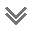

In [3]:
web_page = requests.get("https://www.worldometers.info/coronavirus/#countries")
soup = BeautifulSoup(web_page.text, "html.parser")
print(soup.prettify())

Basic Covid Data

In [4]:
covid_data = soup.find_all("div", class_= "maincounter-number")
print("Coronavirus Cases: ", covid_data[0].text.strip())
print("Deaths : ", covid_data[1].text.strip())
print("Recovered: ", covid_data[2].text.strip())


data = soup.find_all("script", {"type":"text/javascript"})
# for content in data:
#     print(content)

Coronavirus Cases:  144,417,117
Deaths :  3,070,864
Recovered:  122,588,089


In [5]:
results = soup.find(id="main_table_countries_today")
content = results.find_all("td")
# content

In [6]:
clean_data = ""
for data in content:
    clean_data += data.text.strip() + "|"
    clean_data = clean_data.replace("+", "")
    clean_data = clean_data.replace("N/A", "0")
clean_data

'|North America|37,663,818|81,162|850,297|1,558|29,345,701|81,045|7,467,820|17,400||||||North America|||||Asia|35,123,533|472,982|478,404|3,847|30,373,748|320,934|4,271,381|29,935||||||Asia|||||South America|23,770,300|134,564|635,535|4,362|21,421,016|137,230|1,713,749|26,237||||||South America|||||Europe|43,296,157|172,429|986,206|3,835|37,672,445|175,055|4,637,506|32,268||||||Europe|||||Africa|4,500,683|11,470|119,223|304|4,023,018|11,623|358,442|3,856||||||Africa|||||Oceania|61,905|405|1,184|8|41,343|5|19,378|8||||||Australia/Oceania||||||721||15||706||0|0|||||||||||World|144,417,117|873,012|3,070,864|13,914|122,877,977|725,892|18,468,276|109,704|18,527|394.0||||All||||1|USA|32,600,245|63,251|583,288|834|25,171,284|67,668|6,845,673|10,011|98,027|1,754|433,308,501|1,302,933|332,563,810|North America|10|570|1|2|India|15,924,806|315,802|184,672|2,102|13,449,406|179,543|2,290,728|8,944|11,449|133|271,053,392|194,876|1,390,901,395|Asia|87|7,532|5|3|Brazil|14,122,795|71,910|381,687|3,157|

Cleaning Up with Regex

In [7]:
import re

# Got a list of countries from the website
countries = [
    'usa', 'spain', 'italy', 'france', 'germany', 'uk', 'turkey', 'iran', 
    'russia', 'brazil', 'canada', 'belgium', 'netherlands', 'switzerland', 
    'india', 'peru', 'portugal', 'ecuador', 'ireland', 'sweden', 'saudi-arabia', 
    'israel', 'austria', 'mexico', 'singapore', 'japan', 'chile', 'pakistan', 
    'poland', 'romania', 'belarus', 'qatar', 'south-korea', 'united-arab-emirates', 
    'indonesia', 'ukraine', 'denmark', 'serbia', 'philippines', 'norway', 
    'czech-republic', 'australia', 'dominican-republic', 'bangladesh', 'malaysia', 
    'panama', 'colombia', 'finland', 'south-africa', 'egypt', 'morocco', 'argentina', 
    'luxembourg', 'moldova', 'algeria', 'kuwait', 'thailand', 'kazakhstan', 
    'bahrain', 'hungary', 'greece', 'oman', 'croatia', 'uzbekistan', 'iraq', 
    'armenia', 'iceland', 'afghanistan', 'estonia', 'azerbaijan', 'cameroon', 
    'bosnia-and-herzegovina', 'ghana', 'new-zealand', 'lithuania', 'slovenia', 
    'macedonia', 'slovakia', 'cuba', 'bulgaria', 'nigeria', 'cote-d-ivoire', 
    'china-hong-kong-sar', 'djibouti', 'guinea', 'bolivia', 'tunisia', 'latvia', 
    'cyprus', 'andorra', 'albania', 'lebanon', 'niger', 'kyrgyzstan', 'costa-rica', 
    'senegal', 'honduras', 'burkina-faso', 'uruguay', 'sri-lanka', 'san-marino', 
    'channel-islands', 'guatemala', 'georgia', 'democratic-republic-of-the-congo', 
    'malta', 'jordan', 'somalia', 'taiwan', 'reunion', 'mayotte', 'mali', 'kenya', 
    'jamaica', 'state-of-palestine', 'mauritius', 'venezuela', 'el-salvador', 
    'montenegro', 'isle-of-man', 'tanzania', 'viet-nam', 'equatorial-guinea', 
    'sudan', 'paraguay', 'maldives', 'congo', 'rwanda', 'faeroe-islands', 'gabon', 
    'martinique', 'guadeloupe', 'myanmar', 'gibraltar', 'brunei-darussalam', 
    'liberia', 'ethiopia', 'madagascar', 'cambodia', 'trinidad-and-tobago', 
    'french-guiana', 'bermuda', 'cabo-verde', 'aruba', 'togo', 'monaco', 
    'sierra-leone', 'zambia', 'liechtenstein', 'bahamas', 'barbados', 'uganda', 
    'mozambique', 'sint-maarten', 'guyana', 'haiti', 'cayman-islands', 'benin', 
    'libya', 'swaziland', 'french-polynesia', 'guinea-bissau', 'nepal', 'chad', 
    'china-macao-sar', 'syria', 'eritrea', 'saint-martin', 'mongolia', 'malawi', 
    'zimbabwe', 'angola', 'antigua-and-barbuda', 'timor-leste', 'botswana', 
    'central-african-republic', 'laos', 'belize', 'fiji', 'grenada', 'new-caledonia', 
    'curacao', 'dominica', 'namibia', 'saint-kitts-and-nevis', 'saint-lucia', 
    'saint-vincent-and-the-grenadines', 'nicaragua', 'falkland-islands-malvinas', 
    'burundi', 'montserrat', 'turks-and-caicos-islands', 'greenland', 'seychelles', 
    'gambia', 'suriname', 'holy-see', 'papua-new-guinea', 'mauritania', 'bhutan', 
    'british-virgin-islands', 'saint-barthelemy', 'south-sudan', 'western-sahara', 
    'caribbean-netherlands', 'sao-tome-and-principe', 'anguilla', 'saint-pierre-and-miquelon', 
    'yemen', 'china'
]

for c in countries:
    pattern = c+"[,|\d]*"
    data = re.search(pattern, clean_data, re.IGNORECASE)
    if data is not None:
        print(data.group())

USA|32,600,245|63,251|583,288|834|25,171,284|67,668|6,845,673|10,011|98,027|1,754|433,308,501|1,302,933|332,563,810|
Spain|3,446,072|10,232|77,364|148|3,151,587|4,306|217,121|2,288|73,682|1,654|44,374,223|948,788|46,769,371|
Italy|3,904,899|13,844|117,997|364|3,311,267|20,552|475,635|3,076|64,661|1,954|55,885,251|925,404|60,390,143|
France|5,374,288|34,968|101,881|313|4,218,607|37,226|1,053,800|5,959|82,188|1,558|72,936,321|1,115,408|65,389,827|
Germany|3,208,672|27,862|81,382|296|2,824,100|20,500|303,190|4,932|38,199|969|52,737,238|627,827|83,999,616|
UK|4,395,703|2,396|127,327|22|4,166,734|5,301|101,642|300|64,479|1,868|146,043,397|2,142,250|68,172,895|
Turkey|4,446,591|61,967|36,975|362|3,844,342|52,213|565,274|3,398|52,271|435|44,728,595|525,800|85,067,708|
Iran|2,311,813|24,886|67,913|388|1,823,958|13,427|419,942|4,991|27,244|800|14,739,719|173,704|84,855,437|
Russia|4,727,125|8,271|106,706|399|4,352,873|9,644|267,546|2,300|32,381|731|126,500,000|866,528|145,984,885|
Brazil|14,122

Working with CSV Data

In [8]:
owid_df = pd.read_csv("owid-covid-data.csv")
owid_df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [9]:
country_df = owid_df.location.unique()
country_df

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Europe', 'European Union', 'Faeroe Islands', 'Falkland Islands',
       'Fiji', 'Finl

In [14]:
indexer = owid_df[owid_df["location"]=="Philippines"].index
ph_tc = owid_df.loc[indexer, "date": "total_cases"]
ph_tc = ph_tc.dropna()
ph_tc.set_index("date", inplace=True)
ph_tc

,total_cases
date,
2020-01-30,1.0
2020-01-31,1.0
2020-02-01,1.0
2020-02-02,2.0
2020-02-03,2.0
...,...
2021-04-15,904285.0
2021-04-16,914971.0
2021-04-17,926052.0


<AxesSubplot:xlabel='date'>

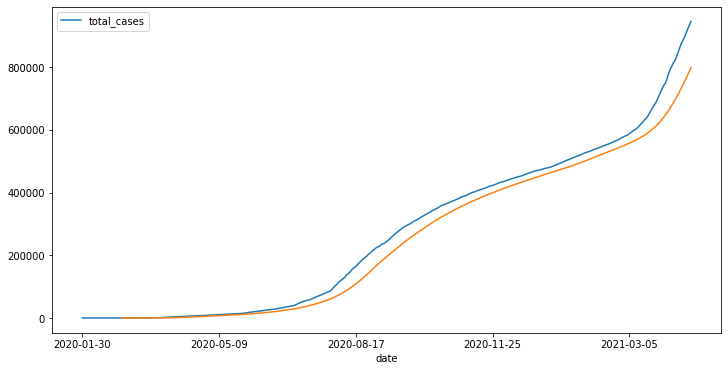

In [20]:
ph_tc.plot(figsize=(12,6))
ph_tc.rolling(window=30).mean()["total_cases"].plot()

Do lockdowns work?

How Does Median Age Effect Death Rate?

How Does Obesity Effect Death Rate?

How Does Diabetes Prevalence Effect Death?

Does More Testing Slow Deathrate?